Clone the repository. It already has:
  * Configuration for the Faster RCNN
  * Bubble files and their COCO annotations
  * ROI pooling and mixed CNN files

In [1]:
!git clone https://github.com/hugalgo/bubble-detection.git
%cd bubble-detection/
!gdown --id 1U3zrDTT1FenyNwinYj2meCHeofvSXqiL -O models/FRCNN/latest.pth

Cloning into 'bubble-detection'...
remote: Enumerating objects: 10947, done.
remote: Counting objects: 100% (10947/10947), done.
remote: Compressing objects: 100% (3710/3710), done.
remote: Total 10947 (delta 7245), reused 10871 (delta 7172), pack-reused 0
Receiving objects: 100% (10947/10947), 19.88 MiB | 19.98 MiB/s, done.
Resolving deltas: 100% (7245/7245), done.
/content/bubble-detection
Downloading...
From: https://drive.google.com/uc?id=1PAHYQWSL9rm1SADaMTsK3AmjjOceMRXn
To: /content/bubble-detection/models/FRCNN/latest.pth
333MB [00:01, 168MB/s]


Install mmdetection that allow us to train a faster RCNN among others

In [0]:
%cd mmdetection/
!sh install.sh
%cd ..

/content/bubble-detection/mmdetection
     |████████████████████████████████| 20.0MB 1.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-bfmgvwut
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-bfmgvwut
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267023 sha256=8f2ce094679b060c392539db1824ab8f1dd28a1b3bea18dde2e758e85706bd29
  Stored in directory: /tmp/pip-ephem-wheel-cache-oztxc3cx/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
Created temporary directory: /tmp/pip-ephem-wh

Training Faster RCNN

In [0]:
!python mmdetection/tools/train.py mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco-bubble.py

2020-05-27 14:18:29,340 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Apr 18 2020, 01:56:04) [GCC 8.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GPU 0: Tesla K80
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.5.0+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=c

Test trained RPN

In [0]:
!python mmdetection/tools/test.py mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco-bubble.py  \
    work_dirs/faster_rcnn_r50_fpn_1x_coco-bubble/latest.pth \
    --show-dir results

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[>>] 2/2, 2.0 task/s, elapsed: 1s, ETA:     0s

Training Mixed CNN

Prepare the data to train:
json with rectangle and circle annotations


In [1]:
%cd bubble-detection/
import scripts.roipooling as roi
XX, YY, ZZ = roi.obtainInOutCrop('data/train_mixedcnn/','data/train_mixedcnn/result.json')
print(XX.shape)
print(YY.shape)
print(ZZ.shape)

/content/bubble-detection
(13608, 10, 10, 3)
(13608, 3)
(13608, 4)


Create the mixed RCNN and training this model

In [2]:
import scripts.mixedcnn as mcnn
from keras.layers import concatenate
from keras.layers.core import Dense
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam # Other optimisers are available
from keras.callbacks import ModelCheckpoint

# Create the MLP and CNN models
mlp = mcnn.create_mlp(4)
cnn = mcnn.create_cnn(10, 10, 3)
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(6, activation="relu")(combinedInput)
x = Dense(3)(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

# Compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(loss="mean_squared_error", metrics=['mse'], optimizer=opt)


model_checkpoint_callback = ModelCheckpoint(
    filepath='models/MixedCNN/best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Train the model
model1_history = model1.fit([ZZ, XX],YY, epochs=100, validation_split = 0.1, batch_size=10, callbacks=[model_checkpoint_callback])

Using TensorFlow backend.


Train on 12247 samples, validate on 1361 samples
Epoch 1/100
12247/12247 [==============================] - 23s 2ms/step - loss: 595.6740 - mse: 595.6740 - val_loss: 42.2244 - val_mse: 42.2244
Epoch 2/100
12247/12247 [==============================] - 17s 1ms/step - loss: 36.4809 - mse: 36.4809 - val_loss: 19.7296 - val_mse: 19.7296
Epoch 3/100
12247/12247 [==============================] - 17s 1ms/step - loss: 24.4275 - mse: 24.4275 - val_loss: 9.9422 - val_mse: 9.9422
Epoch 4/100
12247/12247 [==============================] - 16s 1ms/step - loss: 22.0242 - mse: 22.0242 - val_loss: 9.0319 - val_mse: 9.0319
Epoch 5/100
12247/12247 [==============================] - 17s 1ms/step - loss: 20.4950 - mse: 20.4950 - val_loss: 7.7427 - val_mse: 7.7427
Epoch 6/100
12247/12247 [==============================] - 17s 1ms/step - loss: 19.7174 - mse: 19.7174 - val_loss: 10.0713 - val_mse: 10.0713
Epoch 7/100
12247/12247 [==============================] - 17s 1ms/step - loss: 19.3011 - mse: 19.3011 

Printing all the training + validation predictions


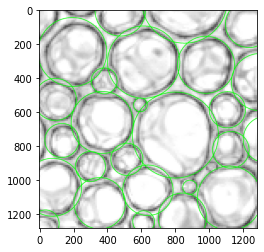

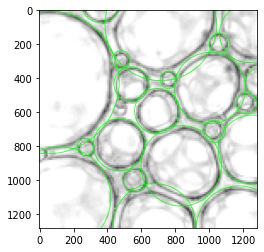

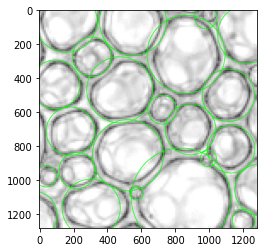

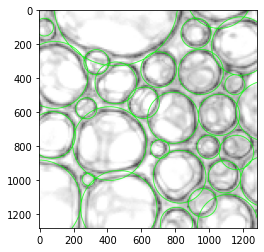

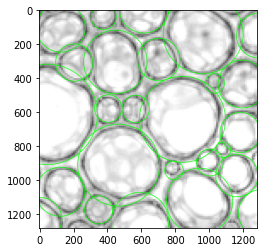

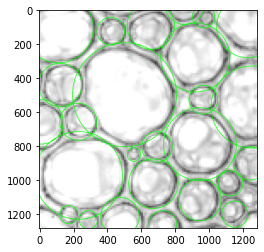

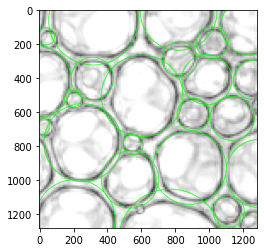

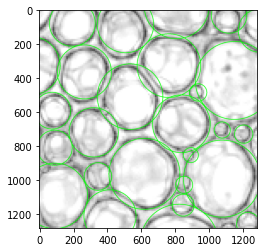

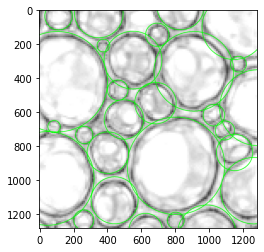

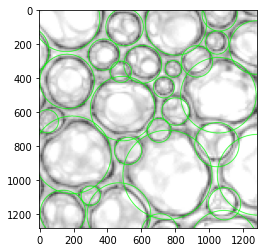

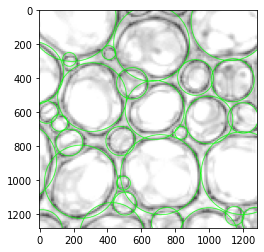

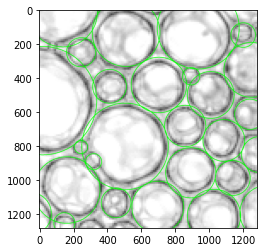

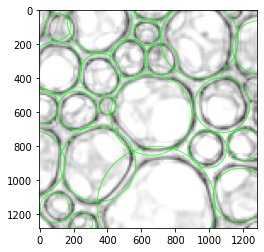

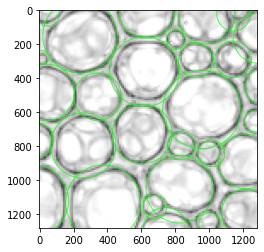

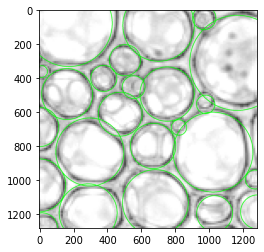

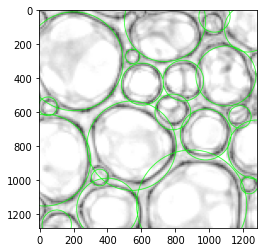

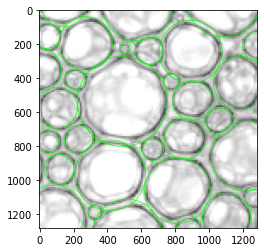

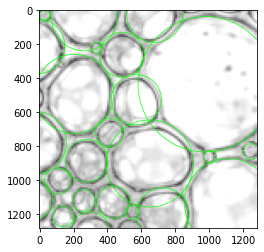

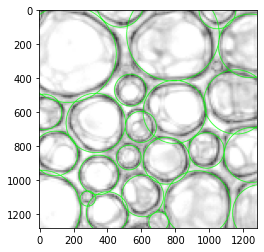

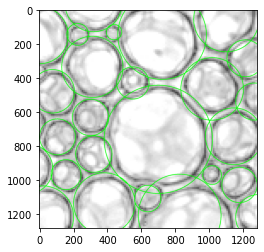

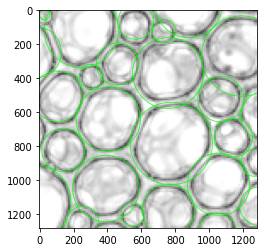

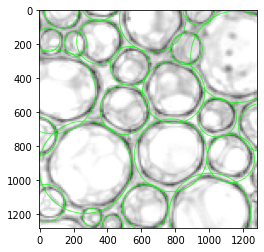

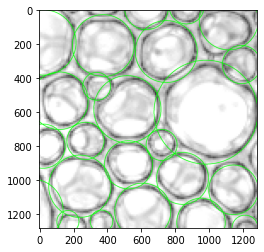

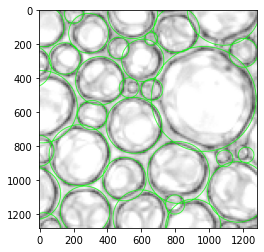

In [0]:
import matplotlib.image as mpimg
import numpy as np
from scipy import interpolate as inpo
import scripts.qbubble as qb
import os

from keras.models import load_model
model = load_model('models/MixedCNN/best.h5')

Yp =  model.predict([ZZ,XX])

impath = 'data/train_mixedcnn/'
jsonpath = 'data/train_mixedcnn/result.json'

arr = os.listdir(impath)
index = 0
dic = roi.loadjson(jsonpath)
for fi in arr:
    if('.png' in fi):
      img = mpimg.imread(impath+fi)[: ,: ,0]
      reg = dic[fi]
      v0 = []
      ii=0
      for ii in range(len(reg)):
        v0.append(np.array([Yp[ii+index][0], Yp[ii+index][1],Yp[ii+index][2]]))
      index+=ii+1
      qb.qbubblePlot(v0, img, s = 10, t = 3)